## Load Required Modules and Packages

fsl/.6.0.6 is also needed.

In [1]:
import shutil
import numpy as np
from bids.layout import BIDSLayout
import os
import nipype.interfaces.ants as ants
import nipype.interfaces.fsl as fsl
import nipype.interfaces.mrtrix3 as mrt
import subprocess

from designer.preprocessing import mrpreproc as mrp
from designer.preprocessing import util, mrinfoutil
from designer.plotting import snrplot
from designer.fitting import dwipy as dp
from designer.postprocessing import filters
%matplotlib notebook

# Path Handling

In [2]:
subject='CC110037'

base_dir = "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/"
os.chdir(base_dir)

raw_data = base_dir + "raw/"
layout = BIDSLayout(raw_data) #for grabbing files with pyBIDS

out_dir = os.path.join(base_dir, subject)
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

working_path = os.path.join(out_dir, 'working.mif')

intermediatepath = os.path.join(out_dir, 'intermediate_nifti')
if not os.path.exists(intermediatepath):
    os.makedirs(intermediatepath, exist_ok=True)
    
qcpath = os.path.join(out_dir, 'metrics_qc')
if not os.path.exists(qcpath):
    os.makedirs(qcpath, exist_ok=True)
    
eddyqcpath = os.path.join(qcpath, 'eddy')
if not os.path.exists(eddyqcpath):
    os.makedirs(eddyqcpath, exist_ok=True)
    
tmp_dir = os.path.join(out_dir, "tmp")
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
    
fitqcpath = os.path.join(out_dir, 'fitting')
if not os.path.exists(fitqcpath):
    os.makedirs(fitqcpath)
    
metricpath = os.path.join(out_dir, 'metrics')
if not os.path.exists(metricpath):
    os.makedirs(metricpath)

# Grab Files
##### DWI

In [3]:
dwi_raw = layout.get(subject=subject, datatype='dwi', extension=['nii.gz', 'nii'])
image = util.DWIParser(dwi_raw)
#concatenate dwi images
dwi_nii = image.cat(path=out_dir, ext='.mif', 
                    force=True
                   )
if np.unique(image.echotime).size > 1:
    multi_echo = True
    multi_echo_start = [0]
    multi_echo_end = [image.vols[0] - 1]
    for idx, vols in enumerate(image.vols[1:]):
        multi_echo_start.append(multi_echo_start[-1] + vols)
        multi_echo_end.append(multi_echo_end[-1] + vols)
    multi_echo_start = [int(x) for x in multi_echo_start]
    multi_echo_end = [int(x) for x in multi_echo_end]
#convert dwi images to working_path
init_nii = os.path.join(out_dir, 'dwi_raw.nii')
mrp.miftonii(input=working_path, 
             output=init_nii, 
             force=True,
             verbose=True
            )

mrconvert -quiet -force /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/dwi0.mif /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/working.mif


mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [100%] copying from "/Volumes/R...essing/CC110037/working.mif" to "/Volumes/R...essing/CC110037/dwi_raw.nii"[0K


##### Fieldmap

In [4]:
fmap_raw = layout.get(subject=subject, datatype='fmap', extension=['nii.gz', 'nii'])
for file in fmap_raw:
    file = file.path
    shutil.copy2(file, tmp_dir)
    
mag_file = os.path.join(tmp_dir, 'sub-' + subject + '_magnitude1.nii.gz')
phase_file = os.path.join(tmp_dir, 'sub-' + subject + '_phasediff.nii.gz')

##### Anatomical

In [5]:
anat_raw = layout.get(subject=subject, datatype='anat', extension=['nii.gz', 'nii'])
for file in anat_raw:
    file = file.path
    shutil.copy2(file, tmp_dir)
    
t1_file = os.path.join(tmp_dir, 'sub-' + subject + '_T1w.nii.gz')

# DWI Preprocessing
Based on pyDESIGNER, with an added fieldmap unwarp step due to the lack of reverse phase encoded B0 images.

In [6]:
#count preprocessing step
step_count = 0

### Denoise

In [7]:
step_count += 1
denoised_name = 'dwi_denoised'
denoised_name_full = str(step_count)+ '_' + denoised_name
nii_denoised = os.path.join(intermediatepath, denoised_name_full + '.nii')
mif_denoised = os.path.join(out_dir, denoised_name_full + '.mif')
nii_noisemap = os.path.join(out_dir, 'noisemap.nii')

mrp.denoise(working_path, mif_denoised, noisemap=True, 
#             force=True, 
            verbose=True
           )
mrp.miftonii(input=mif_denoised, output=nii_denoised, 
#              force=True
            )
os.remove(working_path)
os.rename(mif_denoised, working_path)

dwidenoise: [WARNING] existing output files will be overwritten
dwidenoise: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/working.mif"[0K
dwidenoise: [100%] running MP-PCA denoising[0K


### Degibbs

In [8]:
step_count += 1
degibbs_name = 'dwi_degibbs'
degibbs_name_full = str(step_count)+ '_' + degibbs_name
nii_degibbs = os.path.join(intermediatepath, degibbs_name_full+'.nii')
mif_degibbs = os.path.join(out_dir, degibbs_name_full+'.mif')
mrp.degibbs(input=working_path, output=mif_degibbs, 
#             force=True, 
            verbose=True
           )
mrp.miftonii(input=mif_degibbs, output=nii_degibbs,
#             force=True
            )
os.remove(working_path)
os.rename(mif_degibbs, working_path)

mrdegibbs: [100%] performing Gibbs ringing removal[0K


### Eddy
Named "undistort" to keep consistent with pydesigner, but true undistortion does not happen until the fieldmap is applied. This step just aligns all the images in the timeseries.

In [9]:
step_count += 1
undistorted_name = 'dwi_undistorted'
undistorted_name_full = str(step_count)+ '_' + undistorted_name
nii_undistorted = os.path.join(intermediatepath, undistorted_name_full + '.nii')
mif_undistorted = os.path.join(out_dir, undistorted_name_full + '.mif')
mrp.undistort(input=working_path, output=mif_undistorted, rpe='rpe_header', qc=eddyqcpath,
#               force=True,
#               verbose=True
             )
mrp.miftonii(input=mif_undistorted, output=nii_undistorted,
            force=True
            )
os.remove(working_path)
os.rename(mif_undistorted, working_path)

Applying EPIBOOST
[WARNING] Unable to apply TOPUPBOOST because DWI consists of single PE direction.


dwifslpreproc: [WARNING] DWI header indicates no phase encoding contrast between b=0 images; proceeding without inhomogeneity field estimation


[Warning] unable to remove /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_EPI.mif because it does not exist


In [10]:
mrp.niitomif(input=nii_undistorted, output=mif_undistorted, force=True)
os.remove(working_path)
os.rename(mif_undistorted, working_path)

### Unwarp with Fieldmap

In [11]:
step_count += 1
os.chdir(tmp_dir)

##### Mean B0

In [12]:
tmp_b0_name = 'mean_b0'
nii_tmp_b0 = os.path.join(tmp_dir, tmp_b0_name + '.nii')
mrp.extractmeanbzero(input=working_path,
                    output=nii_tmp_b0,
                    force=True,
                    verbose=True
                    )

dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/B0_ALL.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcalc: [100%] computing: (finite (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/B0_MEAN.mif) ? /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/B0_MEAN.mif : 0)[0K


##### Prepare Magnitude Image and Head Mask
Including reorienting and brain extraction. Head mask is created based on the magnitude brain extraction.

In [13]:
mag_std = fsl.Reorient2Std(in_file=mag_file, output_type='NIFTI').run().outputs.out_file

mag_brain = os.path.join(tmp_dir, 'sub-' + subject + '_magnitude1_brain.nii')
subprocess.run("mri_synthstrip -i " + mag_std + " -o " + mag_brain, shell=True)

mag_head = fsl.DilateImage(in_file=mag_brain, 
                           kernel_shape='box', 
                           kernel_size=20,
                           output_type='NIFTI',
                           operation='mean').run().outputs.out_file

head_mask = fsl.UnaryMaths(in_file=mag_head,
                           output_type='NIFTI',
                           operation='bin').run().outputs.out_file

mag_brain = fsl.ErodeImage(in_file=mag_brain, output_type='NIFTI').run().outputs.out_file

Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/sub-CC110037_magnitude1_reoriented.nii
Processing frame (of 1): 1 done
Masked image saved to: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/sub-CC110037_magnitude1_brain.nii

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474 

Website: https://w3id.org/synthstrip



##### Prepare T1 Image
Including reorienting, bias correcting, and brain extraction. Head image is based on the T1 brain extraction.

In [14]:
t1_std = fsl.Reorient2Std(in_file=t1_file, output_type='NIFTI').run().outputs.out_file

t1_biascorr = ants.N4BiasFieldCorrection(copy_header=True, 
                                         input_image=t1_std).run().outputs.output_image

t1_brain = os.path.join(tmp_dir, 'sub-' + subject + '_T1w_corrected_brain.nii')
subprocess.run("mri_synthstrip -i " + t1_biascorr + " -o " + t1_brain, shell=True)

# t1_head = fsl.DilateImage(in_file=t1_brain,
#                          kernel_shape='box',
#                          kernel_size=20,
#                          operation='mean').run().outputs.out_file

Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/sub-CC110037_T1w_reoriented_corrected.nii
Processing frame (of 1): 1 done
Masked image saved to: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/sub-CC110037_T1w_corrected_brain.nii

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474 

Website: https://w3id.org/synthstrip



CompletedProcess(args='mri_synthstrip -i /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/sub-CC110037_T1w_reoriented_corrected.nii -o /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/tmp/sub-CC110037_T1w_corrected_brain.nii', returncode=0)

##### Reorient Phase Image

In [15]:
phase_std = fsl.Reorient2Std(in_file=phase_file, output_type='NIFTI').run().outputs.out_file

##### Generate Fieldmap
From reoriented/brain extracted magnitude image and reoriented phase image.

In [16]:
fmap = fsl.PrepareFieldmap(in_magnitude=mag_brain,
                           output_type='NIFTI',
                           in_phase=phase_std).run().outputs.out_fieldmap

230726-20:18:13,215 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.215540:Loading volumes
230726-20:18:13,217 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.217823:Phase loaded
230726-20:18:13,226 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.226209:Magnitude loaded
230726-20:18:13,227 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.227410:Mask loaded
230726-20:18:13,229 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.229408:Rewrapping phase range to [-pi,pi]
230726-20:18:13,239 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.239945:Number of phase splits = 8
230726-20:18:13,243 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.243558:Calculating starting matrices (73 by 73)
230726-20:18:13,244 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.244538:Finished connection_matrices
230726-20:18:13,244 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.244950:79 constraints left
230726-20:18:13,245 nipype.interface INFO:
	 stdout 2023-07-26T20:18:13.244950:

##### Generate Voxel Shift Map
Using the prepared mean B0, brain extracted T1, T1 bias corrected image, echo spacing from the DWI DICOM header, generated fieldmap, magnitude head image, and brain extracted magnitude.

In [17]:
epi_reg_outputs = fsl.EpiReg(epi=nii_tmp_b0,
                 t1_brain=t1_brain,
                 t1_head=t1_biascorr,
                 echospacing=0.000360002,
                 fmap=fmap,
                 fmapmag=mag_head,
                 fmapmagbrain=mag_brain,
                 pedir='-y').run().outputs
vsm_reg = epi_reg_outputs.shiftmap

230726-20:18:14,325 nipype.interface INFO:
	 stdout 2023-07-26T20:18:14.324971:Running FAST segmentation
230726-20:21:13,278 nipype.interface INFO:
	 stdout 2023-07-26T20:21:13.278116:FLIRT pre-alignment
230726-20:21:19,104 nipype.interface INFO:
	 stdout 2023-07-26T20:21:19.104567:Registering fieldmap to structural
230726-20:21:25,80 nipype.interface INFO:
	 stderr 2023-07-26T20:21:25.080409:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.
230726-20:21:25,91 nipype.interface INFO:
	 stderr 2023-07-26T20:21:25.091165:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.
230726-20:21:34,231 nipype.interface INFO:
	 stdout 2023-07-26T20:21:34.231248:Running BBR with fieldmap
230726-20:22:44,761 nipype.in

##### Register Head Mask to B0

In [18]:
mat_to_b0 = epi_reg_outputs.fmap2epi_mat
head_mask_reg = fsl.FLIRT(in_file=head_mask, 
                          apply_xfm=True, 
                          in_matrix_file=mat_to_b0, 
                          padding_size=0, 
                          interp='trilinear',
                          output_type='NIFTI',
                          reference=nii_tmp_b0).run().outputs.out_file

##### Unwarp DWI
Using generated voxel shift map and registered head mask.

In [19]:
fmap_file = fsl.FUGUE(in_file=nii_undistorted, 
                      shift_in_file=vsm_reg, 
                      mask_file=head_mask_reg,
                      output_type='NIFTI'
                     ).run().outputs.unwarped_file


##### Convert unwarped DWI to .mif
Including associated bvec, bval, and json files. Associated files will be included in the mif file metadata if they all have the same name as the DWI nii file.

In [20]:
fmap_name = 'dwi_fmap'
fmap_name_full = str(step_count) + '_' + fmap_name

nii_fmap = os.path.join(intermediatepath, fmap_name_full+'.nii')
os.rename(fmap_file, nii_fmap)

bvec_undistorted = os.path.join(intermediatepath, undistorted_name_full+'.bvec')
bvec_fmap = os.path.join(intermediatepath, fmap_name_full+'.bvec')
shutil.copy2(bvec_undistorted, bvec_fmap)

bval_undistorted = os.path.join(intermediatepath, undistorted_name_full+'.bval')
bval_fmap = os.path.join(intermediatepath, fmap_name_full+'.bval')
shutil.copy2(bval_undistorted, bval_fmap)

json_undistorted = os.path.join(intermediatepath, undistorted_name_full+'.json')
json_fmap = os.path.join(intermediatepath, fmap_name_full+'.json')
shutil.copy2(json_undistorted, json_fmap)

mif_fmap = os.path.join(out_dir, fmap_name_full+'.mif')
mrp.niitomif(input=nii_fmap, output=mif_fmap)

os.remove(working_path)
os.rename(mif_fmap, working_path)
shutil.rmtree(tmp_dir)

In [21]:
mif_fmap = os.path.join(out_dir, fmap_name_full+'.mif')
mrp.niitomif(input=nii_fmap, output=mif_fmap, force=True)
# os.remove(working_path)
os.rename(mif_fmap, working_path)

### B1 Bias Field Correction
Calling ANTS via MrTrix as in original DESIGNER.

In [22]:
os.chdir(out_dir)

step_count += 1
b1correct_name = 'dwi_b1correct'
b1correct_name_full = str(step_count) + '_' + b1correct_name
nii_b1correct = os.path.join(intermediatepath, b1correct_name_full + '.nii')
mif_b1correct = os.path.join(out_dir, b1correct_name_full + '.mif')

mrt.DWIBiasCorrect(
    in_file=working_path,
    use_ants=True,
    out_file=mif_b1correct
                  ).run()
mrp.miftonii(
    input=mif_b1correct,
    output=nii_b1correct,
    force=True,
    verbose=True
            )
os.remove(working_path)
os.rename(mif_b1correct, working_path)

230726-20:24:12,906 nipype.interface INFO:
	 stderr 2023-07-26T20:24:12.906053:dwibiascorrect: 
230726-20:24:12,907 nipype.interface INFO:
	 stderr 2023-07-26T20:24:12.906053:dwibiascorrect: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
230726-20:24:12,908 nipype.interface INFO:
	 stderr 2023-07-26T20:24:12.906053:dwibiascorrect: 
230726-20:24:12,909 nipype.interface INFO:
	 stderr 2023-07-26T20:24:12.906053:dwibiascorrect: Generated scratch directory: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/dwibiascorrect-tmp-7PT9IX/
230726-20:24:12,909 nipype.interface INFO:
	 stderr 2023-07-26T20:24:12.906053:Command:  mrconvert /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/working.mif /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/f

mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [100%] copying from "/Volumes/R...C110037/5_dwi_b1correct.mif" to "/Volumes/R...e_nifti/5_dwi_b1correct.nii"[0K


### Smooth
##### Create CSF Mask
Using FSL method as in original DESIGNER.

In [23]:
csfmask_name = 'csf_mask.nii'
csfmask_out = os.path.join(out_dir, csfmask_name)
mrp.csfmask(input=working_path,
           output=csfmask_out,
           method='fsl',
           force=True,
           verbose=True
           )

dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_ALL.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcalc: [100%] computing: (finite (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_MEAN.mif) ? /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_MEAN.mif : 0)[0K


Starting Single Image Segmentation
T2-weighted image
Imagesize : 96 x 96 x 66
Pixelsize : 2 x 2 x 2

1 5.15196
2 5.34183
3 5.55937
4 5.82355
KMeans Iteration 0
KMeans Iteration 1
KMeans Iteration 2
KMeans Iteration 3
KMeans Iteration 4
KMeans Iteration 5
KMeans Iteration 6
KMeans Iteration 7
KMeans Iteration 8
KMeans Iteration 9
KMeans Iteration 10
KMeans Iteration 11
KMeans Iteration 12
KMeans Iteration 13
KMeans Iteration 14
KMeans Iteration 15
KMeans Iteration 16
KMeans Iteration 17
KMeans Iteration 18
Tanaka Iteration 0 bias field 4
Tanaka-inner-loop-iteration=0 MRFWeightsTotal=586566 beta=0.02
Tanaka-inner-loop-iteration=1 MRFWeightsTotal=591053 beta=0.02
Tanaka-inner-loop-iteration=2 MRFWeightsTotal=591113 beta=0.02
Tanaka-inner-loop-iteration=3 MRFWeightsTotal=591114 beta=0.02
Tanaka-inner-loop-iteration=4 MRFWeightsTotal=591114 beta=0.02
 CLASS 1 MEAN 125.94 STDDEV 163.012 CLASS 2 MEAN 187.508 STDDEV 22.2974 CLASS 3 MEAN 256.73 STDDEV 43.5165 CLASS 4 MEAN 353.382 STDDEV 105.938

##### Create Brain Mask

In [24]:
brainmask_name = 'brain_mask.nii'
brainmask_out = os.path.join(out_dir, brainmask_name)
mrp.brainmask(input=working_path,
             output=brainmask_out,
             force=True,
             verbose=True
             )

dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_ALL.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcalc: [100%] computing: (finite (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_MEAN.mif) ? /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_MEAN.mif : 0)[0K


##### Multiply Brain Mask with CSF Mask

In [25]:
subprocess.run("mrcalc -force " + brainmask_out + " " + csfmask_out + " -mult " + csfmask_out, shell=True)

mrcalc: [WARNING] existing output files will be overwritten
mrcalc: [100%] computing: (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/brain_mask.nii * /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/csf_mask.nii)[0K


CompletedProcess(args='mrcalc -force /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/brain_mask.nii /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/csf_mask.nii -mult /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/csf_mask.nii', returncode=0)

##### Apply Smoothing

In [26]:
step_count += 1
smoothing_name = 'dwi_smoothed'
smoothing_name_full = str(step_count) + "_" + smoothing_name
nii_smoothing = os.path.join(intermediatepath, smoothing_name_full + '.nii')
mif_smoothing = os.path.join(out_dir, smoothing_name_full + '.mif')

mrp.smooth(input=working_path,
          csfname=csfmask_out,
          output=mif_smoothing
          )
mrp.miftonii(input=mif_smoothing,
            output=nii_smoothing,
            force=True,
            verbose=True
            )
os.remove(working_path)
os.rename(mif_smoothing, working_path)

Running CSF-excluded smoothing at FWHM = 1.25...


mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [100%] copying from "/Volumes/R...CC110037/6_dwi_smoothed.mif" to "/Volumes/R...te_nifti/6_dwi_smoothed.nii"[0K


### Rician Noise Correction
Using the noise map from the first preprocessing step.

In [27]:
step_count += 1
rician_name = 'dwi_rician'
rician_name = str(step_count) + '_' + rician_name
nii_rician = os.path.join(intermediatepath, rician_name + '.nii')
mif_rician = os.path.join(out_dir, rician_name + '.mif')

mrp.riciancorrect(input=working_path,
                 output=mif_rician,
                 noise=nii_noisemap
                 )
mrp.miftonii(input=mif_rician,
            output=nii_rician,
            force=True,
            verbose=True
            )
os.remove(working_path)
os.rename(mif_rician, working_path)

Running Rician correction...
Path: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037
Name: dwirc
Full: /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/dwirc.nii


mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [100%] copying from "/Volumes/R...g/CC110037/7_dwi_rician.mif" to "/Volumes/R...iate_nifti/7_dwi_rician.nii"[0K


### Extract averaged B0

In [28]:
b0_name = 'B0'
nii_b0 = os.path.join(out_dir, b0_name + '.nii')
mrp.extractmeanbzero(input=working_path,
                    output=nii_b0,
                    force=True,
                    verbose=True
                    )

dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_ALL.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcalc: [100%] computing: (finite (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_MEAN.mif) ? /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/B0_MEAN.mif : 0)[0K


### Extract averaged non-B0 shells

In [29]:
b_shells = [x for x in mrinfoutil.shells(working_path) if x != 0]
b_names = ['B' + str(x) for x in b_shells]
b_paths = [os.path.join(out_dir, x + '.nii') for x in b_names]
for b_value, b_nii in zip(b_shells, b_paths):
    mrp.extractmeanshell(input=working_path,
                        output=b_nii,
                        shell=b_value,
                        force=True,
                        verbose=True
                        )

dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/b1000_ALL.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcalc: [100%] computing: (finite (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/b1000_MEAN.mif) ? /Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/b1000_MEAN.mif : 0)[0K
dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/b2000_ALL.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcalc: [100%] computing: (finite (/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/b2000_MEAN.mif) ? /Volumes/R

### Make preprocessed file

In [30]:
preprocessed = os.path.join(out_dir, 'dwi_preprocessed.nii')
mrp.miftonii(input=working_path,
            output=preprocessed,
            force=True,
            verbose=True
            )
# os.remove(working_path)

mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [100%] copying from "/Volumes/R...essing/CC110037/working.mif" to "/Volumes/R...110037/dwi_preprocessed.nii"[0K


### Compute SNR

Computing SNR: dwi_raw.nii
   * B0...
   * B1000...
   * B2000...
Computing SNR: dwi_preprocessed.nii
   * B0...
   * B1000...
   * B2000...


<IPython.core.display.Javascript object>


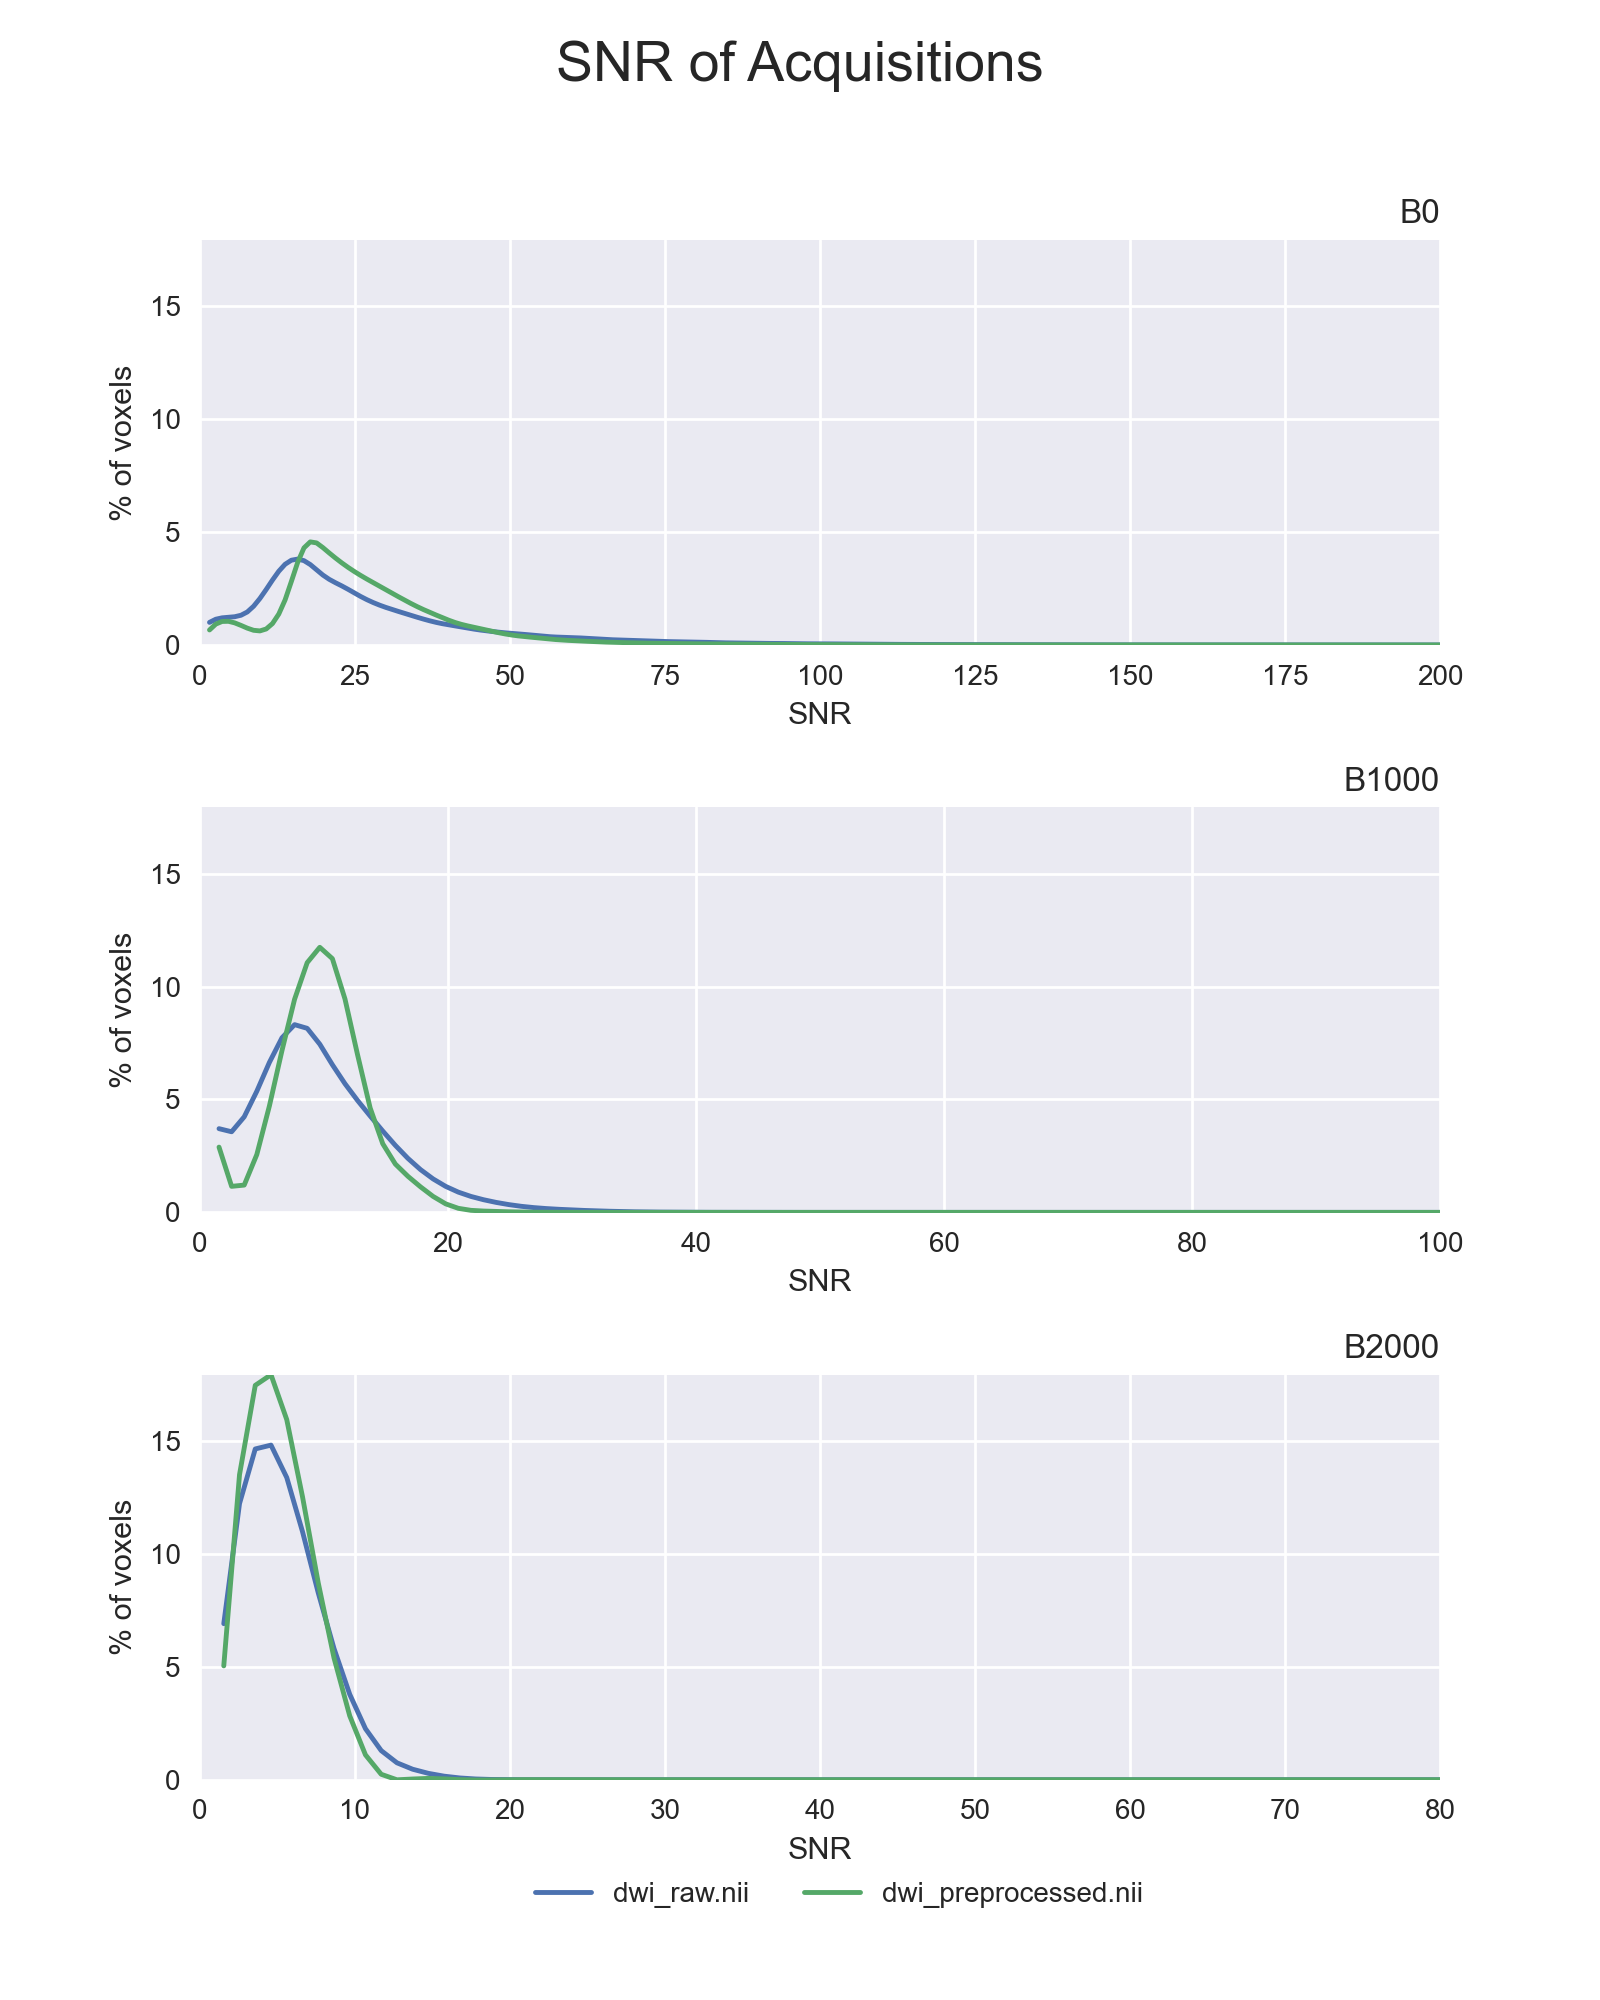

In [31]:
files = []
files.append(init_nii)
files.append(preprocessed)

snr = snrplot.makesnr(dwilist=files,
                     noisepath=nii_noisemap,
                     maskpath=brainmask_out)
snr.makeplot(path=qcpath, smooth=True, smoothfactor=3)

# Tensor Fitting

In [32]:
filetable = {'HEAD': util.DWIFile(preprocessed)}
imPath = filetable['HEAD'].getFull()

Image dwi_preprocessed.nii loaded successfully
Processing with 6 workers...
Protocol(s) detected: DTI, DKI


IRLLS Noise Estimation: [100%]
IRLLS Outlier Detection: [100%]


/Volumes/Research/lazarm03lab/labspace/AD/camcan995/derivatives/fmap_processing/CC110037/fitting/outliers_irlls.nii
Plotting outliers...


<IPython.core.display.Javascript object>


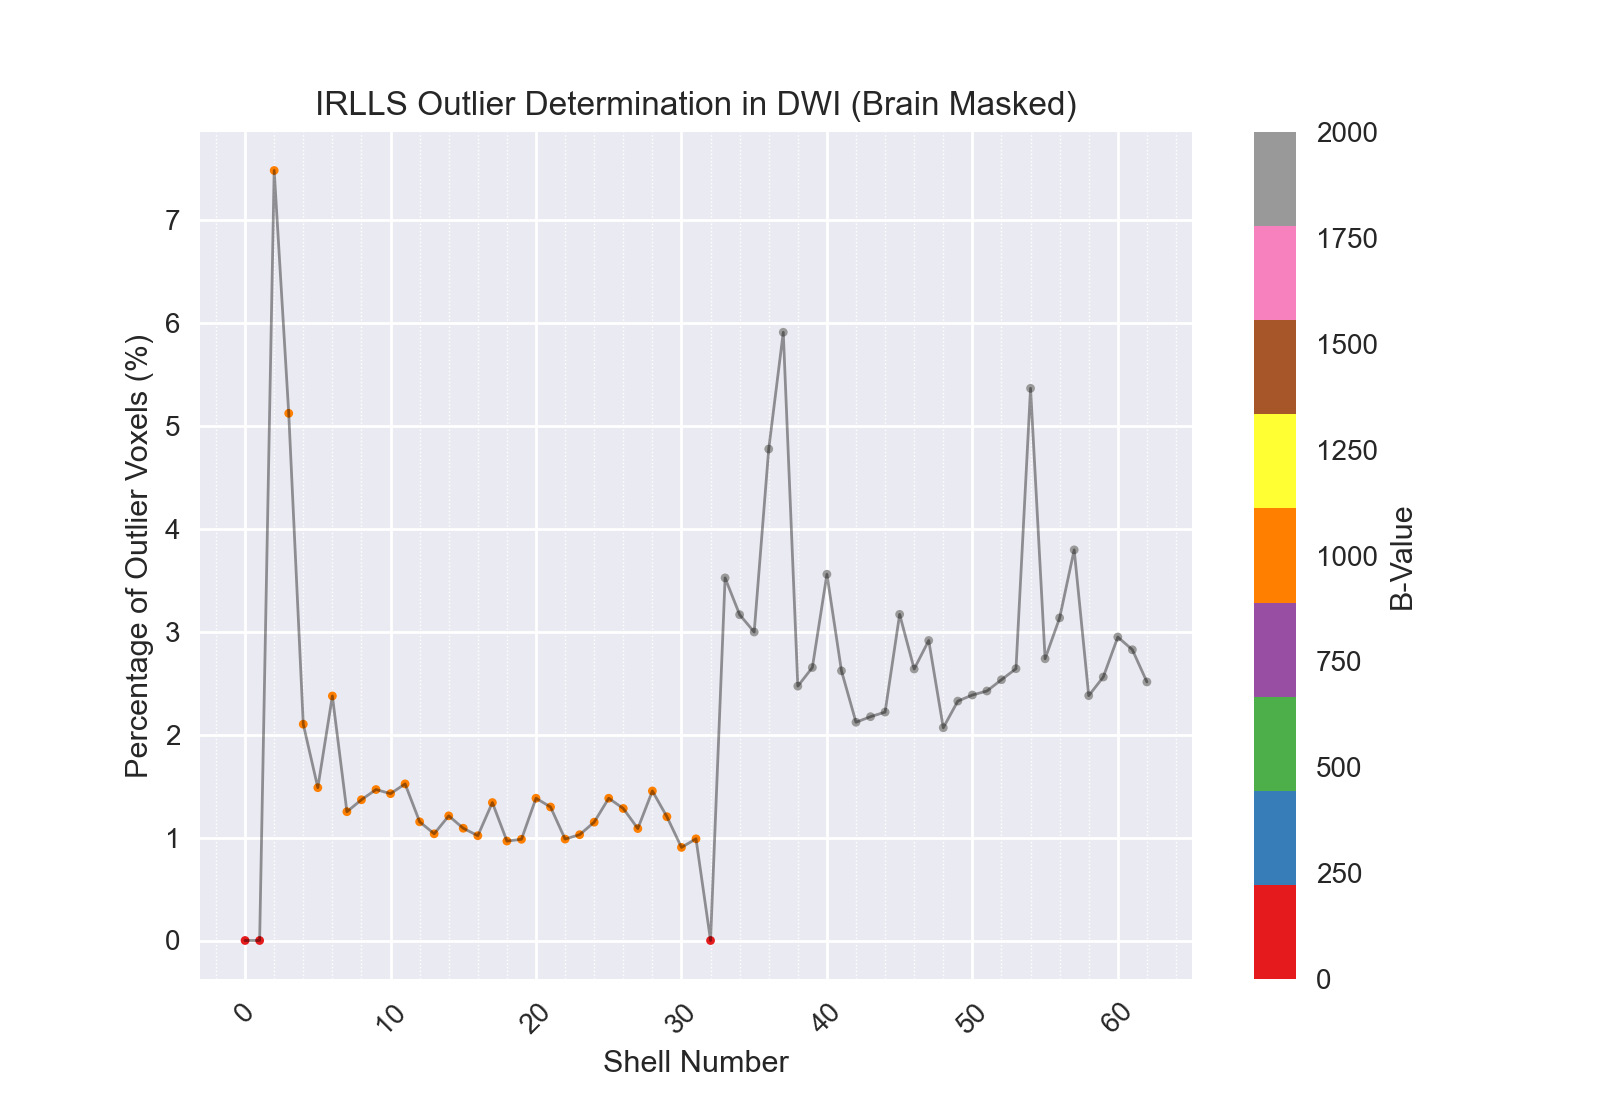

Constrained Tensor Fit: [100%]
AKC Outlier Detection: [100%]
AKC Correction: [100%]
DTI Parameters: [100%]
DTI ODF: [100%]
ODF SH Expansion: [100%]
Computing GFA: [100%]
ODF Peak Detection: [100%]
DKI Parameters: [100%]
Extracting AWF: [100%]
Extracting EAS and IAS: [100%]
DKI ODF: [100%]
ODF SH Expansion: [100%]
Computing GFA: [100%]
ODF Peak Detection: [100%]


In [33]:
ext= '.nii'

dp.fit_regime(
    input=imPath,
    output=metricpath,
#     irlls=False,
#     akc=False,
    prefix=None,
    suffix=None,
    ext=ext,
    l_max=6,
    qcpath=fitqcpath,
    mask=brainmask_out
)

# Fit Standard Model